# CAPM Calculations with Exponential Weights #

### CAPM Model using Weighted Linear Regression Model ###

In [1]:
# Import Libraries

# Data Management
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt

# Statistics
import statsmodels.api as sm

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from data_downloader import get_market_data

In [2]:
# Weights
def wexp(N, half_life):
    c = np.log(0.5) / half_life
    n = np.array(range(N))
    w = np.exp(c * n)
    return np.flip(w / np.sum(w))

# Create the CAPM Function
def capm_regression(
    excess_stock: pd.Series,
    excess_benchmark: pd.Series,
    window: int = 252,
    WLS: bool = False,
):
    
    X = excess_benchmark
    y = excess_stock
    
    if WLS:
        # Create weights with exponential decay
        weights = window * wexp(window, window/2)
        
        # Fit WLS regression
        model = sm.WLS(y, sm.add_constant(X), weights=weights, missing='drop').fit()
    
    else:
        # Fit OLS regression
        model = sm.OLS(y, sm.add_constant(X), missing='drop').fit()
    
    return model
    
    
def rolling_capm_regression(
    stock_returns: pd.Series,
    benchmark_returns: pd.Series,
    daily_rfr: pd.Series,
    window: int = 252,
    WLS: bool = False,
):

    #Align Data
    df = pd.concat([stock_returns, benchmark_returns, daily_rfr], axis=1)
    df = df.dropna()
    df.columns = ['stock_returns', 'benchmark_returns', 'daily_returns']

    # Compute Excess Returns
    excess_stock = df['stock_returns'] - df['daily_returns']
    excess_benchmark = df['benchmark_returns'] - df['daily_returns']

    # Lists
    alphas, betas, sigma = [], [], []
    p_values_alpha, p_values_beta = [], []
    r_squared = []
    dates = []

    for t in range(window, len(excess_stock)):
        # The variables
        X = excess_benchmark.iloc[t-window:t]
        y = excess_stock.iloc[t-window:t]

        # Create the Model
        model = capm_regression(y, X, window=window, WLS=WLS)

        # Avoid KeyError by checking if params exist
        params = model.params
        pvalues = model.pvalues
        r2 = model.rsquared
        hsigma = (model.resid).std()

        # Append values
        alphas.append(params.iloc[0])
        betas.append(params.iloc[1])
        sigma.append(hsigma)
        p_values_alpha.append(pvalues.iloc[0])
        p_values_beta.append(pvalues.iloc[1])
        r_squared.append(r2)
        dates.append(excess_stock.index[t - 1])  # Last date to calculate betas
            
    parameters = pd.DataFrame({
        'alpha': alphas,
        'beta': betas,
        'sigma': sigma,
        'p_value_alpha': p_values_alpha,
        'p_value_beta': p_values_beta,
        'r_squared': r_squared,
    }, index=pd.Index(dates, name="date"))
    
    return parameters

In [15]:
# Get the important data for the Risk-Free Rate
rfr = pd.read_csv(r"..\additional_data\risk_free_rate.csv")
rfr = rfr.set_index('Date')
rfr.index = pd.to_datetime(rfr.index)
rfr = rfr.loc['1999-01-01':]

rfr

,risk_free_rate
Date,
1999-01-05,0.000131
1999-01-06,0.000131
1999-01-07,0.000132
1999-01-08,0.000135
1999-01-11,0.000135
...,...
2024-12-24,0.000128
2024-12-26,0.000127
2024-12-27,0.000128


In [16]:
# Benchmark Data
benchmark = pd.read_csv(r'..\additional_data\benchmark_returns.csv')
benchmark.set_index('Date', inplace=True)
benchmark.index = pd.to_datetime(benchmark.index)
benchmark = benchmark.loc['1999-01-01':]

benchmark

,benchmark_returns
Date,
1999-01-05,0.013491
1999-01-06,0.021899
1999-01-07,-0.002053
1999-01-08,0.004212
1999-01-11,-0.008830
...,...
2024-12-24,0.010982
2024-12-26,-0.000406
2024-12-27,-0.011117


In [18]:
# Stock Data
ticker = 'AAPL'

df_stock = get_market_data(
        ticker=ticker, 
        start_date='1999-01-01', 
        end_date='2025-01-01', 
        returns=True
    )

df_stock

Price,close,high,low,open,volume,returns
Date,,,,,,
1999-01-05,0.325062,0.329752,0.311459,0.314742,1410113600,0.048789
1999-01-06,0.313335,0.331159,0.307706,0.331159,1348569600,-0.036742
1999-01-07,0.337727,0.338196,0.316149,0.317087,1429019200,0.074963
1999-01-08,0.337727,0.351798,0.330221,0.349453,678832000,0.000000
1999-01-11,0.344293,0.345700,0.336788,0.343355,560974400,0.019257
...,...,...,...,...,...,...
2024-12-24,257.286682,257.296626,254.386957,254.586262,23234700,0.011413
2024-12-26,258.103729,259.179926,256.718662,257.276679,27237100,0.003171
2024-12-27,254.685867,257.784882,252.164818,256.917934,42355300,-0.013331


In [19]:
# Calculate the Betas using WLS
betas_wls = rolling_capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = True
)

betas_wls

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2000-01-03,0.004124,1.335080,0.033902,0.061861,1.610109e-10,0.151160
2000-01-04,0.003760,1.418454,0.033937,0.088489,2.263622e-12,0.179098
2000-01-05,0.003944,1.440879,0.033645,0.072148,1.069699e-12,0.183923
2000-01-06,0.003109,1.440651,0.033840,0.164452,3.132338e-12,0.177000
2000-01-07,0.003157,1.447918,0.033837,0.157100,1.032129e-12,0.184153
...,...,...,...,...,...,...
2024-12-23,0.000740,0.899419,0.012014,0.316006,8.361973e-20,0.282869
2024-12-24,0.000759,0.900453,0.012005,0.302529,4.981026e-20,0.285806
2024-12-26,0.000793,0.900734,0.011998,0.280218,4.828996e-20,0.285981


In [20]:
# Calculate the Betas using OLS
betas_ols = rolling_capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = False,
)

betas_ols

,alpha,beta,sigma,p_value_alpha,p_value_beta,r_squared
date,,,,,,
2000-01-03,0.003098,1.367727,0.033900,0.149316,4.729743e-12,0.174330
2000-01-04,0.002830,1.401103,0.033936,0.187767,6.192500e-13,0.187425
2000-01-05,0.003134,1.446645,0.033645,0.141285,1.185196e-13,0.197934
2000-01-06,0.002460,1.450553,0.033839,0.250698,1.388130e-13,0.196935
2000-01-07,0.002512,1.455423,0.033837,0.240796,7.046515e-14,0.201213
...,...,...,...,...,...,...
2024-12-23,0.000219,0.953338,0.012006,0.773731,1.063998e-19,0.281499
2024-12-24,0.000251,0.954133,0.011997,0.742306,7.563907e-20,0.283438
2024-12-26,0.000291,0.955349,0.011991,0.702394,6.770532e-20,0.284067


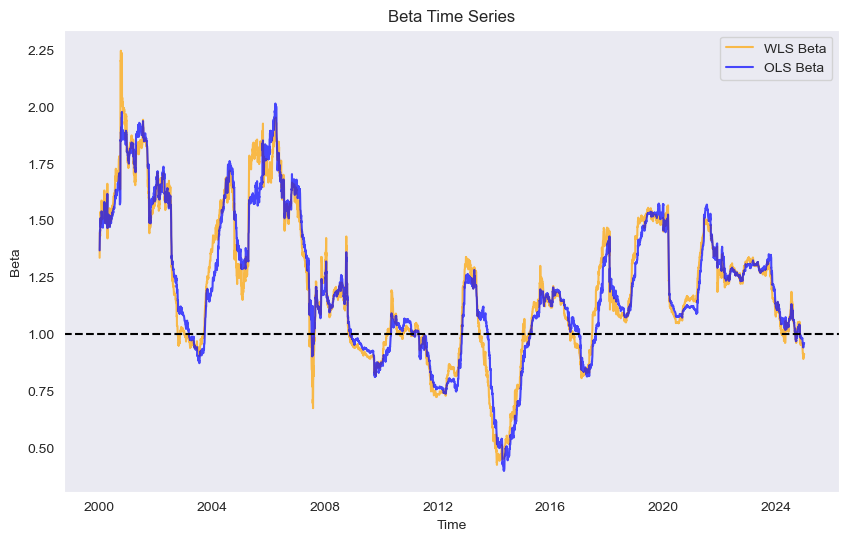

In [21]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['beta'], label='WLS Beta', color='orange', alpha=0.7)
plt.plot(betas_ols['beta'], label='OLS Beta', color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='dashed')

# Config
plt.title('Beta Time Series')
plt.xlabel('Time')
plt.ylabel('Beta')
plt.legend()

# Show
plt.grid()
plt.show()

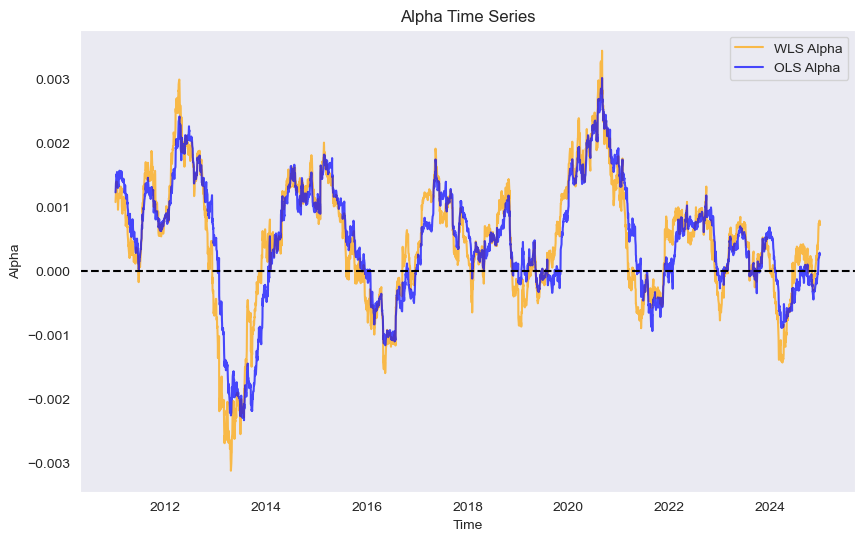

In [10]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['alpha'], label='WLS Alpha', color='orange', alpha=0.7)
plt.plot(betas_ols['alpha'], label='OLS Alpha', color='blue', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='dashed')

# Config
plt.title('Alpha Time Series')
plt.xlabel('Time')
plt.ylabel('Alpha')
plt.legend()

# Show
plt.grid()
plt.show()

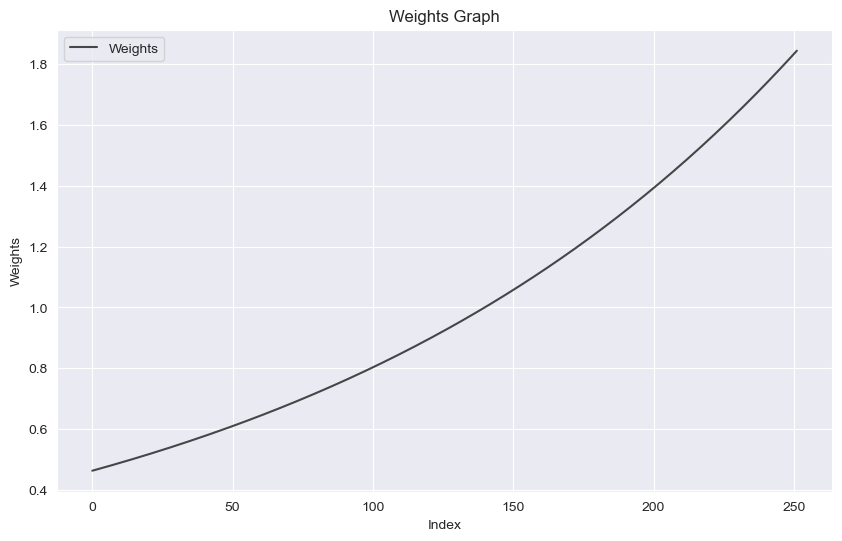

In [11]:
# Create Plot
weights = 252 * wexp(252, 126)

plt.figure(figsize=(10, 6))
plt.plot(weights, label='Weights', color='black', alpha=0.7)

# Config
plt.title('Weights Graph')
plt.xlabel('Index')
plt.ylabel('Weights')
plt.legend()

# Show
plt.show()

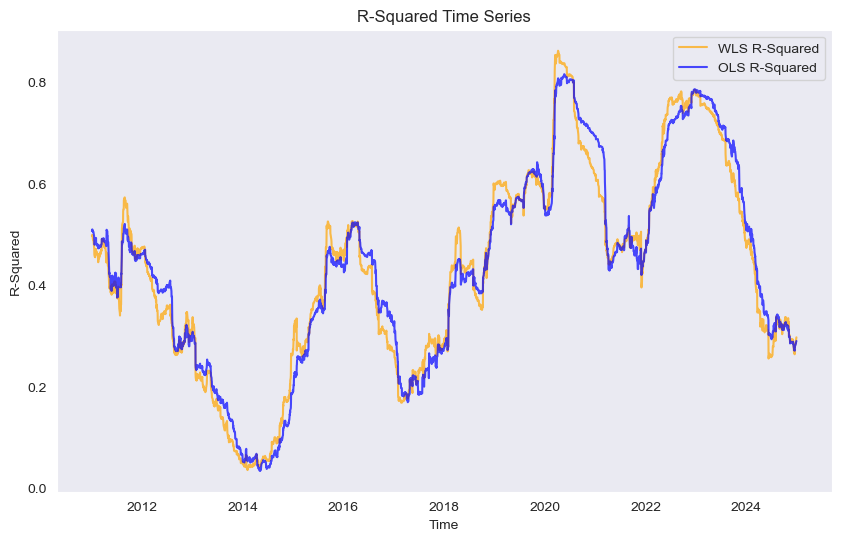

In [12]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['r_squared'], label='WLS R-Squared', color='orange', alpha=0.7)
plt.plot(betas_ols['r_squared'], label='OLS R-Squared', color='blue', alpha=0.7)

# Config
plt.title('R-Squared Time Series')
plt.xlabel('Time')
plt.ylabel('R-Squared')
plt.legend()

# Show
plt.grid()
plt.show()

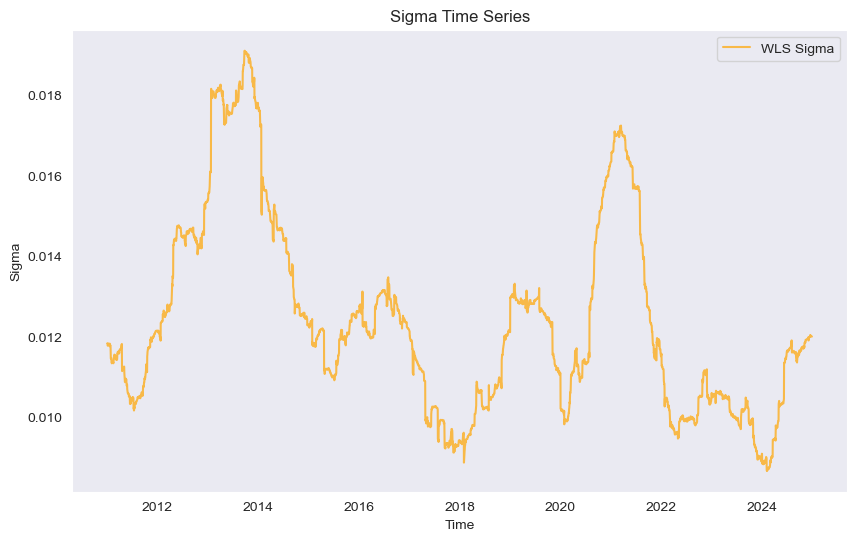

In [13]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(betas_wls['sigma'], label='WLS Sigma', color='orange', alpha=0.7)

# Config
plt.title('Sigma Time Series')
plt.xlabel('Time')
plt.ylabel('Sigma')
plt.legend()

# Show
plt.grid()
plt.show()

In [14]:
# Compute the Factor Contribution to Returns
def compute_factor_contributions(factor_returns, betas):
    # Multiply Elements
    contribution = (factor_returns * betas)

    return contribution

# Compute the Residual Returns
def compute_residual_returns(stock_excess_returns, factor_contributions):
    return stock_excess_returns - factor_contributions

In [19]:
# Create the Residual Returns DF
capm_returns_df = pd.DataFrame(index=betas_wls.index)

capm_returns_df['stock_excess_returns'] = df_stock['returns'] - rfr['risk_free_rate']
capm_returns_df['market_excess_returns'] = benchmark['benchmark_returns'] - rfr['risk_free_rate']
capm_returns_df['betas'] = betas_wls['beta']

capm_returns_df['factor_returns'] = compute_factor_contributions(
    capm_returns_df['market_excess_returns'], 
    capm_returns_df['betas']
)

capm_returns_df['residual_returns'] = compute_residual_returns(
    capm_returns_df['stock_excess_returns'],
    capm_returns_df['factor_returns']
)

capm_returns_df

,stock_excess_returns,market_excess_returns,betas,factor_returns,residual_returns
date,,,,,
2011-01-03,0.026815,0.011158,1.402191,0.015646,0.011169
2011-01-04,-0.003258,-0.001407,1.401956,-0.001972,-0.001286
2011-01-05,0.073830,0.004898,1.420018,0.006955,0.066875
2011-01-06,0.129527,-0.002220,1.396809,-0.003101,0.132628
2011-01-07,0.027460,-0.001939,1.392110,-0.002699,0.030159
...,...,...,...,...,...
2024-12-23,0.036105,0.007133,2.551350,0.018199,0.017906
2024-12-24,0.003803,0.010855,2.523614,0.027393,-0.023590
2024-12-26,-0.002198,-0.000533,2.524104,-0.001345,-0.000852


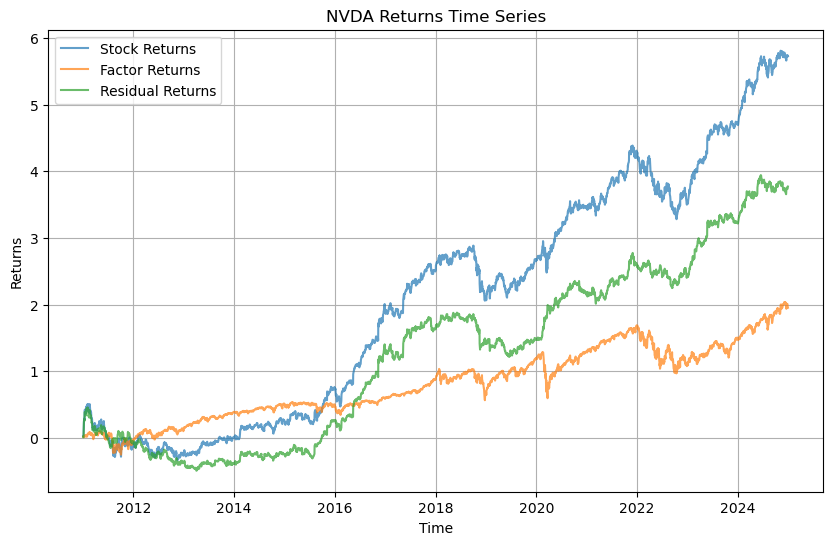

In [20]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(capm_returns_df['stock_excess_returns'].cumsum(), label='Stock Returns', alpha=0.7)
plt.plot(capm_returns_df['factor_returns'].cumsum(), label='Factor Returns', alpha=0.7)
plt.plot(capm_returns_df['residual_returns'].cumsum(), label='Residual Returns', alpha=0.7)

# Config
plt.title(f'{ticker} Returns Time Series')
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()

# Show
plt.grid()
plt.show()

### Variance Decomposition ###

Variance Decomposition

1) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0 + \beta_1\mu_M + u_i) $

Distributing the Variance Operator (assuming betas are constant):

2) $ \mathrm{Var}(\mu_i) = \mathrm{Var}(\beta_0) + \mathrm{Var}(\beta_1\mu_M ) + \mathrm{Var}(u_i)$
3) $ \sigma_i^2 = \beta_1^2\sigma_M^2 + \sigma_u^2 $

Recalling the alternative calculation of the beta coefficient (check the guide in the Module 4 Files)

4) $ \sigma_i^2 = \left( \rho_{i,M}\frac{\sigma_i}{\sigma_M} \right)^2 \sigma_M^2 + \sigma_u^2 $
5) $ \sigma_i^2 = \rho_{i,M}^2\sigma_i^2 + \sigma_u^2 $

Finally, solving for the variance of the errors:

6) $ \left( 1 - \rho_{i,M}^2 \right) \sigma_i^2 = \sigma_u^2 $

In [22]:
# First Calculate the Variance of the Stock
stock_variance = df_stock['returns'].var()

stock_variance

0.0008077681853001824

In [23]:
# Now calculate the Variance of the Market
market_variance = benchmark['benchmark_returns'].var()

market_variance

0.00011856024022996

In [24]:
# And the Residuals Variance
stocks_market_corr = df_stock['returns'].corr(benchmark['benchmark_returns'])

resid_variance = (1 - stocks_market_corr*stocks_market_corr) * stock_variance

resid_variance

0.00048785369530467024

In [25]:
beta_model = capm_regression(
    df_stock['returns'],
    benchmark['benchmark_returns'],
    rfr['risk_free_rate'],
    WLS = False,
)

print(beta_model.summary())

                            OLS Regression Results                            
Dep. Variable:                returns   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     2473.
Date:                Mon, 04 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:15:01   Log-Likelihood:                 9032.3
No. Observations:                3773   AIC:                        -1.806e+04
Df Residuals:                    3771   BIC:                        -1.805e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0008      0.00

In [26]:
# Extract the beta
beta = beta_model.params.iloc[1]

beta

1.6426590105580017

In [27]:
# Calculated Stock Variance
calculated_stock_variance = (beta*beta * market_variance) + resid_variance

calculated_stock_variance

0.000807768185300182

In [28]:
# Note that the error is practically 0
(stock_variance - calculated_stock_variance).round(2)

0.0

In [29]:
# Now check how much of the variance is explained by the Market and how much by the errors

print(f'Residuals Variance Percentage: {(resid_variance / stock_variance).round(5) * 100}%')
print(f'Market Variance Percentage: {100 - ((resid_variance / stock_variance).round(5) * 100)}%')

Residuals Variance Percentage: 60.394999999999996%
Market Variance Percentage: 39.605000000000004%
